# Images classification between - cats, dogs, and monkeys
## Step 1 - Import libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ypy-websocket 0.8.2 requires aiofiles<23,>=22.1.0, but you have aiofiles 23.1.0 which is incompatible.


In [3]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

## Step 2 - Download images of cats, dogs, and monkeys

In [4]:
# Imports
from fastai.vision.all import *
from fastcore.all import *
from duckduckgo_search import ddg_images

In [5]:
def search_images(term, max_images=50):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [6]:
# ! rm -r /kaggle/working/photos
# ! rm  /kaggle/working/*.jpg

In [7]:
# Get a cat photo
urls = search_images('cat photo', max_images=1)
urls[0]

Searching for 'cat photo'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'https://static.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg'

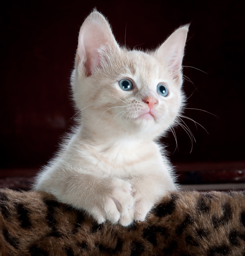

In [8]:
from fastdownload import download_url
dest = 'cat.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'dog photo'


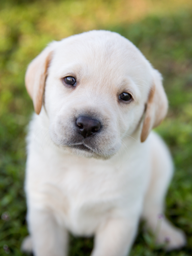

In [9]:
# Get a dog photo and download it
download_url(search_images('dog photo', max_images=5)[1], 'dog.jpg', show_progress=False)
Image.open('dog.jpg').to_thumb(256,256)

Searching for 'monkey phots'


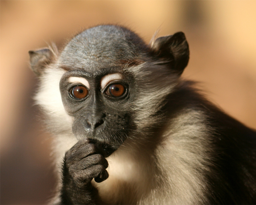

In [10]:
# Get a monkey photo and download it
# Getting more monkey images and choosing one with just 1 monkey
download_url(search_images('monkey phots', max_images=5)[2], 'monkey.jpg', show_progress=False)
Image.open('monkey.jpg').to_thumb(256,256)

In [11]:
# Now get photos of cat, dog and monkey and others like forest
searches = 'cat','dog', 'monkey', 'forest' 
path = Path('photos')
from time import sleep

if not path.exists():
    path.mkdir()
    for o in searches:
        dest = (path/o)
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest, urls=search_images(f'{o} photo'))
        sleep(10)  # Pause between searches to avoid over-loading server  
        resize_images(path/o, max_size=400, dest=path/o)

Searching for 'cat photo'
Searching for 'dog photo'
Searching for 'monkey photo'
Searching for 'forest photo'


## Step 3 - Raw data to Dataloaders

To remove all the failed images, you can use unlink on each of them. Note that, like most fastai functions that return a collection, verify_images returns an object of type L, which includes the map method. This calls the passed function on each element of the collection:

In [12]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

6

In [13]:
orig_images = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
)

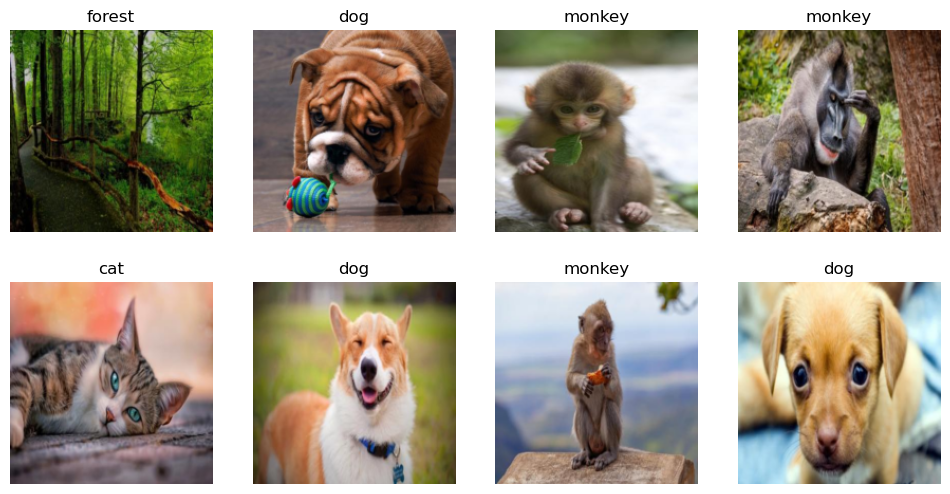

In [14]:
orig_dls = orig_images.dataloaders(path, bs=32)
orig_dls.show_batch(max_n=8)

## Step 4 - Data Augmentation

Data augmentation refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes. For natural photo images such as the ones we are using here, a standard set of augmentations that we have found work pretty well are provided with the aug_transforms function. Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time. To tell fastai we want to use these transforms on a batch, we use the batch_tfms parameter (note that we're not using RandomResizedCrop in this example, so you can see the differences more clearly; we're also using double the amount of augmentation compared to the default, for the same reason):

In [15]:
aug_images = orig_images.new(item_tfms=Resize(192), batch_tfms=aug_transforms(mult=2))
aug_dls = aug_images.dataloaders(path, bs=32)

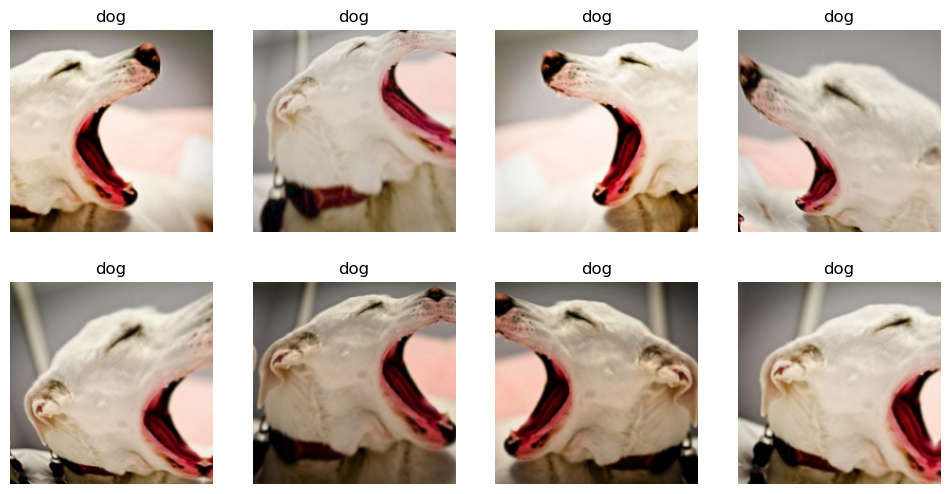

In [16]:
aug_dls.train.show_batch(max_n=8, nrows=2, unique=True)

And now try RandomResizedCrop

In [17]:
rrc_images = orig_images.new(item_tfms=RandomResizedCrop(192, min_scale=0.5), batch_tfms=aug_transforms())
rrc_dls = rrc_images.dataloaders(path, bs=32)

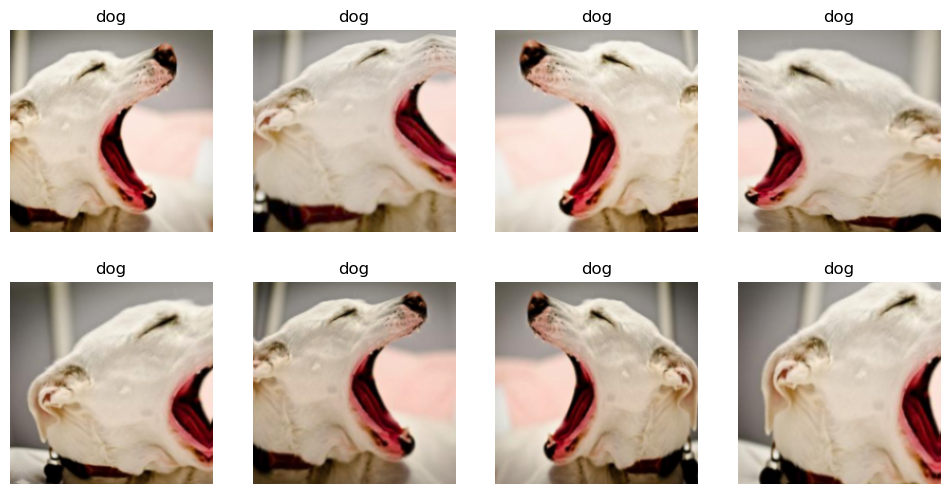

In [18]:
rrc_dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Step 4 - Train our model

To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a DataBlock, and view sample images from it:

we are using the RandomResizedCrop images

In [19]:
learn = vision_learner(rrc_dls, resnet18, metrics=error_rate)
# for 5 epochs as its a more complicated classifictaion as just between bird and forest
learn.fine_tune(5) 

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,2.154167,0.502420,0.162162,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.363380,0.148495,0.054054,00:18
1,0.242657,0.014528,0.000000,00:18
2,0.195257,0.005218,0.000000,00:18
3,0.148218,0.003901,0.000000,00:18
4,0.122393,0.004399,0.000000,00:18


## Step 5 - Check Confusion matrix

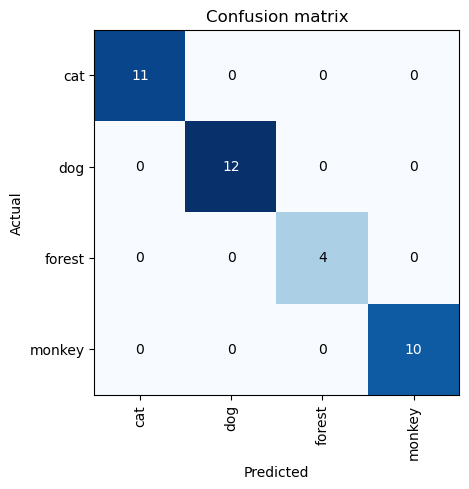

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

No errors, wow!

## Step 6 - Use the model for inferencing

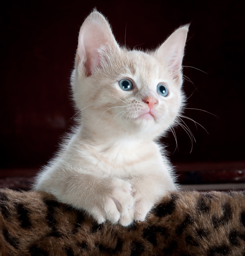

In [21]:
dest = 'cat.jpg'
im = Image.open(dest)
im.to_thumb(256,256)

In [22]:
#  The predict method returns three things: the decoded prediction (here False for dog), 
# the index of the predicted class and the tensor of probabilities of all classes in the order of their indexed labels
is_cat,index,probs = learn.predict(PILImage.create('cat.jpg'))
print(f"This is a: {is_cat}.")
print(f"Probability it's a cat: {probs[index]:.4f}")

This is a: cat.
Probability it's a cat: 1.0000


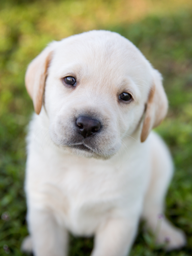

In [23]:
dest = 'dog.jpg'
im = Image.open(dest)
im.to_thumb(256,256)

In [24]:
is_dog,index,probs = learn.predict(PILImage.create('dog.jpg'))
print(f"This is a: {is_dog}.")
print(f"Probability it's a dog: {probs[index]:.4f}")

This is a: dog.
Probability it's a dog: 1.0000


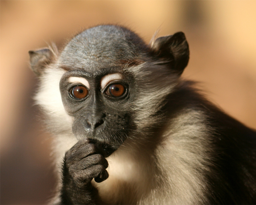

In [25]:
dest = 'monkey.jpg'
im = Image.open(dest)
im.to_thumb(256,256)

In [26]:
is_monkey,index,probs = learn.predict(PILImage.create('monkey.jpg'))
print(f"This is a: {is_monkey}.")
print(f"Probability it's a monkey: {probs[index]:.4f}")

This is a: monkey.
Probability it's a monkey: 0.9977


## Step 7 - Export Trained model
Now we can export our trained Learner. This contains all the information needed to run the model:

In [27]:
learn.export('cdm_model.pkl')

Finally, open the Kaggle sidebar on the right if it's not already, and find the section marked "Output". Open the /kaggle/working folder, and you'll see model.pkl. Click on it, then click on the menu on the right that appears, and choose "Download". After a few seconds, your model will be downloaded to your computer, where you can then create your app that uses the model.

## Step 8 - Load the saved model and try inference

In [28]:
learn = load_learner('cdm_model.pkl')

Searching for 'dog photo'


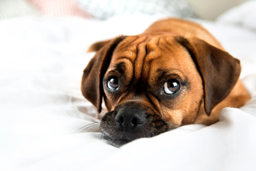

In [39]:
from fastdownload import download_url
urls = search_images('dog photo', max_images=10)
urls[4]
dest = 'newdog.jpg'
download_url(urls[8], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [40]:
is_dog,index,probs = learn.predict(PILImage.create('newdog.jpg'))
print(f"This is a: {is_dog}.")
print(f"Probability it's a dog: {probs[index]:.4f}")

This is a: dog.
Probability it's a dog: 0.9973
